In [1]:
# !pip install lalsuite
# !pip install nestle

In [2]:
#!/usr/bin/env python
"""
Tutorial to demonstrate running parameter estimation on a binary neutron star
system taking into account tidal deformabilities.

This example estimates the masses using a uniform prior in both component masses
and also estimates the tidal deformabilities using a uniform prior in both
tidal deformabilities
"""
#Hello!
# ! git clone -b BinaryLove https://git.ligo.org/cjhaster/bilby.git
import sys
sys.path.insert(0,'/home/marc.penuliar/bilby') 
import bilby
import numpy as np

No version information file '.version' found


In [3]:
# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "New_Example_Code"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

In [4]:
# Set up a random seed for result reproducibility.  This is optional!
# np.random.seed(88170235)

In [5]:
# We are going to inject a binary neutron star waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# aligned spins of both black holes (chi_1, chi_2), etc.
injection_parameters = dict(
    mass_1=1.5,
    mass_2=1.3,
    chi_1=0.02,
    chi_2=0.02,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    lambda_1=545.21397414,
    lambda_2=1346.68123938,
)


In [6]:

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
sampling_frequency = 4096 #2048 
start_time = injection_parameters["geocent_time"] + 2 - duration



In [7]:
# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomD_NRTidalv2",
    reference_frequency=50.0,
    minimum_frequency=40.0,
)


In [8]:
# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)


02:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


In [9]:
# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)


02:32 bilby INFO    : Injected signal in H1:
02:32 bilby INFO    :   optimal SNR = 34.42
02:32 bilby INFO    :   matched filter SNR = 33.08-0.09j
02:32 bilby INFO    :   mass_1 = 1.5
02:32 bilby INFO    :   mass_2 = 1.3
02:32 bilby INFO    :   chi_1 = 0.02
02:32 bilby INFO    :   chi_2 = 0.02
02:32 bilby INFO    :   luminosity_distance = 50.0
02:32 bilby INFO    :   theta_jn = 0.4
02:32 bilby INFO    :   psi = 2.659
02:32 bilby INFO    :   phase = 1.3
02:32 bilby INFO    :   geocent_time = 1126259642.413
02:32 bilby INFO    :   ra = 1.375
02:32 bilby INFO    :   dec = -1.2108
02:32 bilby INFO    :   lambda_1 = 545.21397414
02:32 bilby INFO    :   lambda_2 = 1346.68123938
02:32 bilby INFO    : Injected signal in L1:
02:32 bilby INFO    :   optimal SNR = 27.87
02:32 bilby INFO    :   matched filter SNR = 28.45-0.12j
02:32 bilby INFO    :   mass_1 = 1.5
02:32 bilby INFO    :   mass_2 = 1.3
02:32 bilby INFO    :   chi_1 = 0.02
02:32 bilby INFO    :   chi_2 = 0.02
02:32 bilby INFO    :   lu

[{'plus': array([ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j, -0.+0.j,  0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j, -0.+0.j,  0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j, -0.+0.j,  0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [10]:
# Load the default prior for binary neutron stars.
# We're going to sample in chirp_mass, symmetric_mass_ratio, lambda_tilde, and
# delta_lambda rather than mass_1, mass_2, lambda_1, and lambda_2.
# BNS have aligned spins by default, if you want to allow precessing spins
# pass aligned_spin=False to the BNSPriorDict
priors = bilby.gw.prior.BNSPriorDict()
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    "luminosity_distance",
    # "phase",
]:
    priors[key] = injection_parameters[key]
del priors["mass_ratio"], priors["lambda_1"], priors["lambda_2"]
priors["chirp_mass"] = bilby.core.prior.Gaussian(
    1.215, 0.1, name="chirp_mass", unit="$M_{\\odot}$"
)
priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
    0.1, 0.25, name="symmetric_mass_ratio"
)
priors["lambda_tilde"] = bilby.core.prior.Uniform(0, 5000, name="lambda_tilde")
priors["delta_lambda"] = bilby.core.prior.Uniform(-500, 1000, name="delta_lambda")

# Kept the phase in just in case to see the difference. Update: i changed it to be exactly the same. Same output? 

priors['phase'] = bilby.core.prior.Uniform(
    0, 2 *np.pi, boundary='periodic', name='phase')

02:32 bilby INFO    : No prior given, using default BNS priors in /home/marc.penuliar/bilby/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


In [11]:
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
# likelihood = bilby.gw.GravitationalWaveTransient(
#     interferometers=interferometers,
#     waveform_generator=waveform_generator,
# )

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
    phase_marginalization=True,
    priors = priors
    
)

02:33 bilby INFO    : Running for label 'New_Example_Code', output will be saved to 'outdir'
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
02:33 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundan

No version information file '.version' found
it=  1923 logz=1319.3014241


03:35 bilby INFO    : Sampling time: 1:01:34.232806
03:35 bilby INFO    : Reconstructing marginalised parameters.
03:35 bilby INFO    : Cached samples dict out of date, ignoring


  0%|          | 0/2024 [00:00<?, ?it/s]

03:42 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/2024 [00:00<?, ?it/s]

03:42 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/2024 [00:00<?, ?it/s]

04:17 bilby INFO    : Summary of results:
nsamples: 2024
ln_noise_evidence: -194064.407
ln_evidence: -192744.730 +/-  0.413
ln_bayes_factor: 1319.677 +/-  0.413



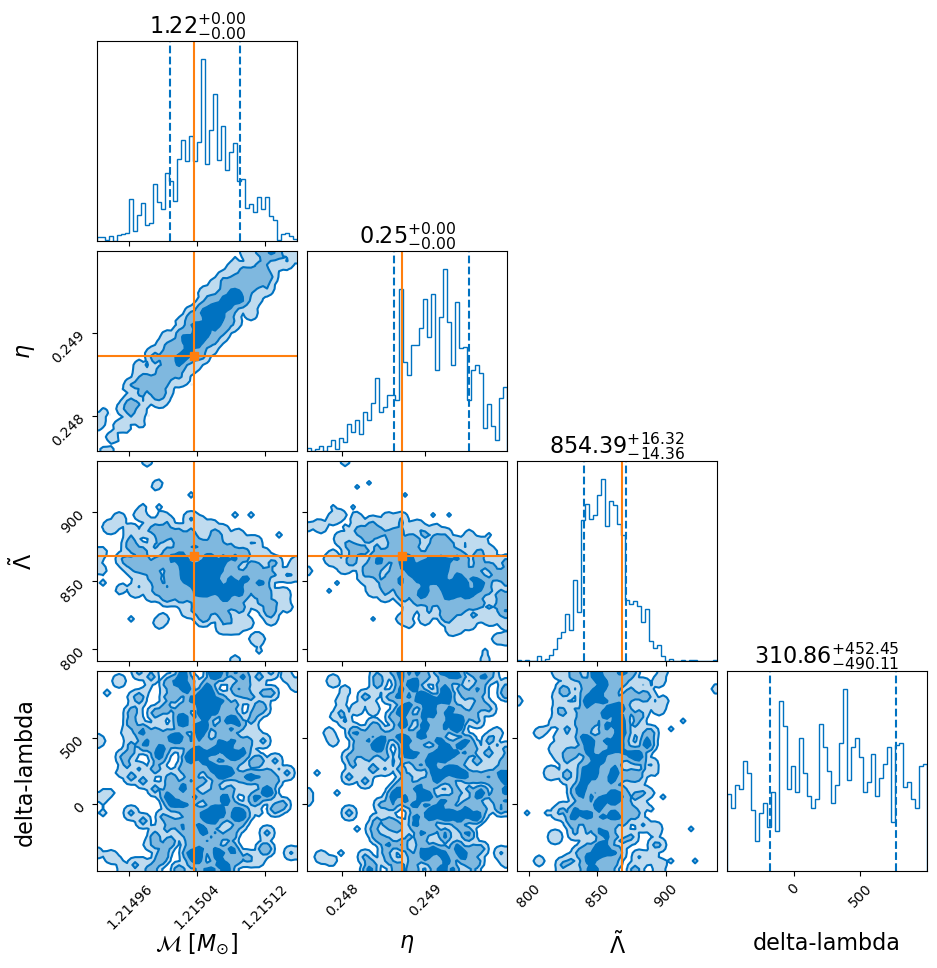

In [12]:
# Run sampler.  In this case we're going to use the `nestle` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nestle",
    npoints=100,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
)

result.plot_corner()

In [13]:
import seaborn as sns 

# sns.jointplot( x=result.posterior['lambda_1'], y=result.posterior['lambda_2'],kind = 'kde').fig.suptitle("Bilby_Example_Code")
# sns.title.set(title='hello')

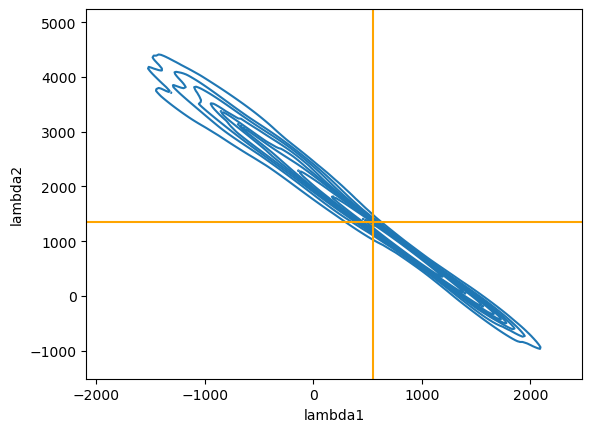

In [14]:
result.posterior['lambda1'] = result.posterior.apply(lambda row :
        bilby.gw.conversion.lambda_tilde_delta_lambda_tilde_to_lambda_1_lambda_2(
                row['lambda_tilde'],row['delta_lambda'],row['mass_1'],row['mass_2']
                )[0], axis = 1)
result.posterior['lambda2'] = result.posterior.apply(lambda row :
        bilby.gw.conversion.lambda_tilde_delta_lambda_tilde_to_lambda_1_lambda_2(
                row['lambda_tilde'],row['delta_lambda'],row['mass_1'],row['mass_2']
                )[1], axis = 1)

# sns.jointplot( x=result.posterior['lambda1'], y=result.posterior['lambda2'],kind = 'kde').fig.suptitle("Bilby_Example_Code")
# sns.kdeplot( x=result.posterior['lambda1'], y=result.posterior['lambda_2'],color = 'r', label='LambdaSymm_&_LambdaAsymm')

# import seaborn as sns 

# sns.jointplot( x=result.posterior['lambda_1'], y=result.posterior['lambda_2'],kind = 'kde').fig.suptitle("Bilby_Example_Code")
# sns.title.set(title='hello')
sns.kdeplot( x=result.posterior['lambda1'], y=result.posterior['lambda2'])
import matplotlib.pyplot as plt

# import matplotlib.pyplot as plt

#lambda 2 y
plt.axhline(y=result.injection_parameters['lambda_2'], color="orange", linestyle="-")
#lambda 2 x
plt.axvline(x= result.injection_parameters['lambda_1'], color="orange")
#Add the point
plt.scatter(result.injection_parameters['lambda_1'], result.injection_parameters['lambda_2'],color = 'orange')